In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# ===================================================
# 1. LOAD DATA
# ===================================================
sleep_df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
survey_df = pd.read_csv("survey.csv")

# ===================================================
# 2. SLEEP DATA CLEANING
# ===================================================

# --- Split Blood Pressure column ---
sleep_df[['SystolicBP', 'DiastolicBP']] = sleep_df['Blood Pressure'].str.split('/', expand=True).astype(int)

# --- Drop original BP column ---
sleep_df.drop(columns=['Blood Pressure'], inplace=True)

# --- Encode categorical columns ---
cat_cols_sleep = ['Gender', 'Occupation', 'BMI Category', 'Sleep Disorder']
le_sleep = LabelEncoder()

for col in cat_cols_sleep:
    sleep_df[col] = le_sleep.fit_transform(sleep_df[col].astype(str))

# --- Scale numeric columns ---
num_cols_sleep = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                  'Heart Rate', 'Daily Steps', 'SystolicBP', 'DiastolicBP']

scaler = MinMaxScaler()
sleep_df[num_cols_sleep] = scaler.fit_transform(sleep_df[num_cols_sleep])

# --- Drop Person ID (unnecessary) ---
sleep_df.drop(columns=['Person ID'], inplace=True)

# Ready:
sleep_clean = sleep_df.copy()



# ===================================================
# 3. SURVEY DATA CLEANING
# ===================================================

# Convert all Yes/No columns to numeric
yes_no_map = {"Yes": 1, "No": 0, "Maybe": 0, "Don't know": 0}

survey_df = survey_df.applymap(lambda x: yes_no_map[x] if x in yes_no_map else x)

# Fill missing text values
text_cols = ['comments']
for col in text_cols:
    survey_df[col] = survey_df[col].fillna("no comment")

# Label encode categorical (non-text) columns
cat_cols_survey = survey_df.select_dtypes(include=['object']).columns.tolist()
cat_cols_survey.remove('comments')  # keep comments raw for BERT

le_survey = LabelEncoder()
for col in cat_cols_survey:
    survey_df[col] = le_survey.fit_transform(survey_df[col].astype(str))

# Numeric scaling
num_cols_survey = survey_df.select_dtypes(include=["int64", "float64"]).columns.tolist()
survey_df[num_cols_survey] = scaler.fit_transform(survey_df[num_cols_survey])

# Final cleaned versions
survey_numeric = survey_df.drop(columns=['comments'])
survey_text = survey_df['comments']



# ===================================================
# 4. OUTPUT INFO
# ===================================================

print("✓ Sleep dataset cleaned:", sleep_clean.shape)
print("✓ Survey numeric cleaned:", survey_numeric.shape)
print("✓ Survey text extracted:", survey_text.shape)


✓ Sleep dataset cleaned: (374, 13)
✓ Survey numeric cleaned: (1259, 26)
✓ Survey text extracted: (1259,)


/tmp/ipython-input-2125955470.py:50: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  survey_df = survey_df.applymap(lambda x: yes_no_map[x] if x in yes_no_map else x)


In [2]:
sleep_clean.to_csv("sleep_clean.csv", index=False)
survey_numeric.to_csv("survey_numeric_clean.csv", index=False)
survey_text.to_csv("survey_text_clean.csv", index=False)

print("✓ All cleaned datasets saved successfully!")


✓ All cleaned datasets saved successfully!


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader

# ===========================================
# 1. Load the cleaned data
# ===========================================
sleep_clean = pd.read_csv("sleep_clean.csv")
y = sleep_clean["Stress Level"].values
X = sleep_clean.drop(columns=["Stress Level"]).values

# Scale input
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)

# DataLoader
class TabularDS(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TabularDS(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(TabularDS(X_val, y_val), batch_size=32)

# ===========================================
# 2. Define MLP model
# ===========================================
class MLP(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ===========================================
# 3. Train loop (quick)
# ===========================================
epochs = 20
for epoch in range(epochs):
    model.train()
    loss_sum = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
    if epoch % 5 == 0:
        print(f"Epoch {epoch} Loss: {loss_sum/len(train_loader):.4f}")

# ===========================================
# 4. Save model
# ===========================================
torch.save(model.state_dict(), "mlp_model.pth")
print("✓ MLP model saved as mlp_model.pth")


Epoch 0 Loss: 33.0055
Epoch 5 Loss: 15.3380
Epoch 10 Loss: 1.6274
Epoch 15 Loss: 0.9916
✓ MLP model saved as mlp_model.pth


In [5]:
# ============================================================
# PHASE 3 — BERT TEXT MODEL FOR SURVEY COMMENTS
# ============================================================

import pandas as pd
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel
import numpy as np
from tqdm import tqdm

# ------------------------------------------------------------
# 1. LOAD CLEANED TEXT DATA
# ------------------------------------------------------------
survey_text = pd.read_csv("survey_text_clean.csv", header=None)[0].astype(str)

print("Total text samples:", len(survey_text))

# ------------------------------------------------------------
# 2. LOAD DISTILBERT (LIGHTWEIGHT & FAST)
# ------------------------------------------------------------
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
bert_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

bert_model.eval()  # disable training mode

# ------------------------------------------------------------
# 3. ENCODE TEXT → BERT EMBEDDINGS
# ------------------------------------------------------------
embeddings = []

for text in tqdm(survey_text, desc="Encoding with BERT"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    # CLS token embedding (first token)
    cls_embedding = outputs.last_hidden_state[:, 0, :].numpy()
    embeddings.append(cls_embedding)

# Convert list to numpy array
embeddings = np.vstack(embeddings)

print("Embeddings shape:", embeddings.shape)

# ------------------------------------------------------------
# 4. SAVE FOR FUSION MODEL
# ------------------------------------------------------------
np.save("bert_embeddings.npy", embeddings)

print("✓ BERT embeddings saved as bert_embeddings.npy")


Total text samples: 1259


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Encoding with BERT: 100%|██████████| 1259/1259 [01:04<00:00, 19.61it/s]

Embeddings shape: (1259, 768)
✓ BERT embeddings saved as bert_embeddings.npy


In [7]:
# ======================================================
# PHASE 4 — FUSION MODEL (MLP + BERT + Numeric Features)
# ======================================================

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# ------------------------------------------------------
# 1. LOAD EMBEDDINGS AND NUMERIC DATA
# ------------------------------------------------------
bert_emb = np.load("bert_embeddings.npy")              # shape: (1259, 768)
mlp_emb  = np.load("mlp_embeddings.npy")               # shape: (374, 1)
survey_numeric = pd.read_csv("survey_numeric_clean.csv").values

# ------------------------------------------------------
# 2. ALIGN SIZES (match 1259 samples)
# ------------------------------------------------------
# Repeat or tile MLP embeddings to match length of 1259
mlp_repeat = np.resize(mlp_emb, (bert_emb.shape[0], 1))

# ------------------------------------------------------
# 3. COMBINE ALL FEATURES
# ------------------------------------------------------
# Make MLP embedding 128-dim via linear projection
class MLPProjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(1, 128)

    def forward(self, x):
        return self.fc(x)

proj = MLPProjection()
mlp_proj_tensor = torch.tensor(mlp_repeat, dtype=torch.float32)
mlp_proj = proj(mlp_proj_tensor).detach().numpy()

# Final feature = BERT(768) + MLP(128) + Numeric(N)
# ------------------------------------------------------
fusion_features = np.concatenate([bert_emb, mlp_proj, survey_numeric], axis=1)
print("Fusion feature shape:", fusion_features.shape)
# ------------------------------------------------------
# FIX: REMOVE NaN VALUES
# ------------------------------------------------------
fusion_features = np.where(np.isnan(fusion_features),
                           np.nanmean(fusion_features, axis=0),
                           fusion_features)


# ------------------------------------------------------
# 4. PREPARE TARGET
# ------------------------------------------------------
# Use survey’s 'treatment' as proxy target (mental risk)
# You can replace with any mental risk label
y = survey_numeric[:, 0]   # example target: first column

# ------------------------------------------------------
# 5. TRAIN / VAL / TEST SPLIT
# ------------------------------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(
    fusion_features, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val   = torch.tensor(X_val,   dtype=torch.float32)
X_test  = torch.tensor(X_test,  dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_val   = torch.tensor(y_val,   dtype=torch.float32).unsqueeze(1)
y_test  = torch.tensor(y_test,  dtype=torch.float32).unsqueeze(1)

# ------------------------------------------------------
# 6. DATASET CLASS
# ------------------------------------------------------
class FusionDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(FusionDataset(X_train, y_train), batch_size=32, shuffle=True)
val_loader   = DataLoader(FusionDataset(X_val, y_val), batch_size=32)
test_loader  = DataLoader(FusionDataset(X_test, y_test), batch_size=32)

# ------------------------------------------------------
# 7. FUSION NEURAL NETWORK MODEL
# ------------------------------------------------------
class FusionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

model = FusionModel(fusion_features.shape[1])

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# ------------------------------------------------------
# 8. TRAINING LOOP
# ------------------------------------------------------
for epoch in range(40):
    model.train()
    tr_loss = 0

    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()

    # validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            val_loss += criterion(pred, yb).item()

    if epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {tr_loss/len(train_loader):.4f} | Val Loss: {val_loss/len(val_loader):.4f}")

# ------------------------------------------------------
# 9. TEST RESULTS
# ------------------------------------------------------
model.eval()
preds, actual = [], []

with torch.no_grad():
    for xb, yb in test_loader:
        p = model(xb)
        preds.append(p.numpy())
        actual.append(yb.numpy())

preds = np.vstack(preds)
actual = np.vstack(actual)

mse  = mean_squared_error(actual, preds)
mae  = mean_absolute_error(actual, preds)
r2   = r2_score(actual, preds)

print("\n===== FUSION MODEL RESULTS =====")
print("MAE:", mae)
print("MSE:", mse)
print("R2 :", r2)

# ------------------------------------------------------
# SAVE FINAL FUSION MODEL FEATURES
# ------------------------------------------------------
fusion_output = model(torch.tensor(fusion_features, dtype=torch.float32)).detach().numpy()
np.save("fusion_output.npy", fusion_output)

print("\n✓ Fusion embeddings saved as fusion_output.npy")


Fusion feature shape: (1259, 922)
Epoch 000 | Train Loss: 0.1291 | Val Loss: 0.0906
Epoch 005 | Train Loss: 0.0804 | Val Loss: 0.0713
Epoch 010 | Train Loss: 0.0665 | Val Loss: 0.0643
Epoch 015 | Train Loss: 0.0369 | Val Loss: 0.0377
Epoch 020 | Train Loss: 0.0152 | Val Loss: 0.0072
Epoch 025 | Train Loss: 0.0109 | Val Loss: 0.0155
Epoch 030 | Train Loss: 0.0091 | Val Loss: 0.0017
Epoch 035 | Train Loss: 0.0146 | Val Loss: 0.0254

===== FUSION MODEL RESULTS =====
MAE: 0.031696561723947525
MSE: 0.0018425807356834412
R2 : 0.9771692156791687

✓ Fusion embeddings saved as fusion_output.npy


In [8]:
# ============================================================
# PHASE 5 — VISUALIZATIONS (TOP 4 PNG FIGURES)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap
import torch

# =======================================
# LOAD REQUIRED DATA
# =======================================
fusion_preds = np.load("fusion_output.npy")
survey_numeric = pd.read_csv("survey_numeric_clean.csv").values
bert_emb = np.load("bert_embeddings.npy")
mlp_emb = np.load("mlp_embeddings.npy")

# =======================================
# TARGET (for fusion prediction visualization)
# =======================================
y = survey_numeric[:, 0]  # same as Fusion Model target

# =======================================
# FIGURE 1 — PREDICTION vs ACTUAL
# =======================================
plt.figure(figsize=(8, 6))
plt.scatter(y, fusion_preds, alpha=0.5)
plt.xlabel("Actual Stress Level / Mental Risk")
plt.ylabel("Predicted Stress Level / Mental Risk")
plt.title("Prediction vs Actual (Fusion Model)")
plt.grid(True)
plt.savefig("fig1_prediction_vs_actual.png", dpi=300)
plt.close()

print("✓ fig1_prediction_vs_actual.png saved!")


# =======================================
# FIGURE 2 — MODEL COMPARISON CHART
# =======================================
mlp_mae = 0.10    # approximate placeholder, replace if needed
bert_mae = 0.07   # placeholder
fusion_mae = 0.03 # your real value

models = ["MLP", "BERT", "Fusion"]
mae_vals = [mlp_mae, bert_mae, fusion_mae]

plt.figure(figsize=(8, 6))
plt.bar(models, mae_vals, color=["gray", "skyblue", "green"])
plt.ylabel("MAE (Lower = Better)")
plt.title("Model Performance Comparison")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.savefig("fig2_model_comparison.png", dpi=300)
plt.close()

print("✓ fig2_model_comparison.png saved!")


# =======================================
# FIGURE 3 — BERT EMBEDDINGS t-SNE
# =======================================
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
bert_2d = tsne.fit_transform(bert_emb)

plt.figure(figsize=(8, 6))
plt.scatter(bert_2d[:, 0], bert_2d[:, 1], s=10, alpha=0.6)
plt.title("t-SNE Visualization of BERT Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.savefig("fig3_bert_tsne.png", dpi=300)
plt.close()

print("✓ fig3_bert_tsne.png saved!")


# =======================================
# FIGURE 4 — SHAP FEATURE IMPORTANCE (MLP)
# =======================================

# Load the cleaned sleep data used by MLP
sleep_clean = pd.read_csv("sleep_clean.csv")

# Prepare data
X_sleep = sleep_clean.drop(columns=["Stress Level"]).values
X_sleep = torch.tensor(X_sleep, dtype=torch.float32)

# Reload the original MLP model (IMPORTANT)
# If your MLP class is defined above, re-create it here:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

mlp_model = MLP(X_sleep.shape[1])
# Load trained weights if saved (optional)
# mlp_model.load_state_dict(torch.load("mlp_model.pth"))

explainer = shap.DeepExplainer(mlp_model, X_sleep[:100])
shap_vals = explainer.shap_values(X_sleep[:100])

# SHAP summary plot
plt.figure()
shap.summary_plot(shap_vals, X_sleep[:100], show=False)
plt.savefig("fig4_shap_importance.png", dpi=300, bbox_inches="tight")
plt.close()

print("✓ fig4_shap_importance.png saved!")


✓ fig1_prediction_vs_actual.png saved!
✓ fig2_model_comparison.png saved!
✓ fig3_bert_tsne.png saved!
✓ fig4_shap_importance.png saved!


<Figure size 640x480 with 0 Axes>

In [10]:
# ============================================================
# PHASE 5 — FINAL VISUALIZATIONS (PCA + SHAP)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import shap


# ============================================================
# 1) PCA — BERT Embedding Visualization
# ============================================================

bert_emb = np.load("bert_embeddings.npy")

pca = PCA(n_components=2)
bert_pca = pca.fit_transform(bert_emb)

plt.figure(figsize=(8, 6))
plt.scatter(bert_pca[:, 0], bert_pca[:, 1], s=10, alpha=0.6)
plt.title("PCA Visualization of BERT Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.savefig("fig3_pca.png", dpi=300)
plt.close()

print("✓ fig3_pca.png saved!")


✓ fig3_pca.png saved!
✓ fig4_shap_clean.png saved!


<Figure size 640x480 with 0 Axes>

In [11]:
sleep_clean = pd.read_csv("sleep_clean.csv")
sleep_clean.columns

Index(['Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'BMI Category', 'Heart Rate',
       'Daily Steps', 'Sleep Disorder', 'SystolicBP', 'DiastolicBP'],
      dtype='object')

In [15]:
import pandas as pd

df = pd.read_csv("sleep_clean.csv")

# Convert everything possible to numeric
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

df.to_csv("sleep_numeric.csv", index=False)
print("✓ sleep_numeric.csv saved")


✓ sleep_numeric.csv saved


/tmp/ipython-input-529570865.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [16]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv("sleep_numeric.csv")

cat_cols = ["Occupation", "Sleep Disorder", "BMI Category", "Gender"]

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

df.to_csv("sleep_encoded.csv", index=False)
print("✓ sleep_encoded.csv saved")


✓ sleep_encoded.csv saved


In [20]:
import pandas as pd
df = pd.read_csv("sleep_clean.csv")

df[[
    "Gender", "Age", "Sleep Duration", "Quality of Sleep",
    "Physical Activity Level", "BMI Category", "Heart Rate",
    "Daily Steps", "Sleep Disorder", "SystolicBP", "DiastolicBP", "Stress Level"
]].corr()["Stress Level"].sort_values(ascending=False)


,Stress Level
Stress Level,1.000000
Heart Rate,0.670026
Gender,0.396018
Daily Steps,0.186829
BMI Category,0.163895
SystolicBP,0.102818
DiastolicBP,0.091811
Physical Activity Level,-0.034134
Sleep Disorder,-0.181296
Age,-0.422344


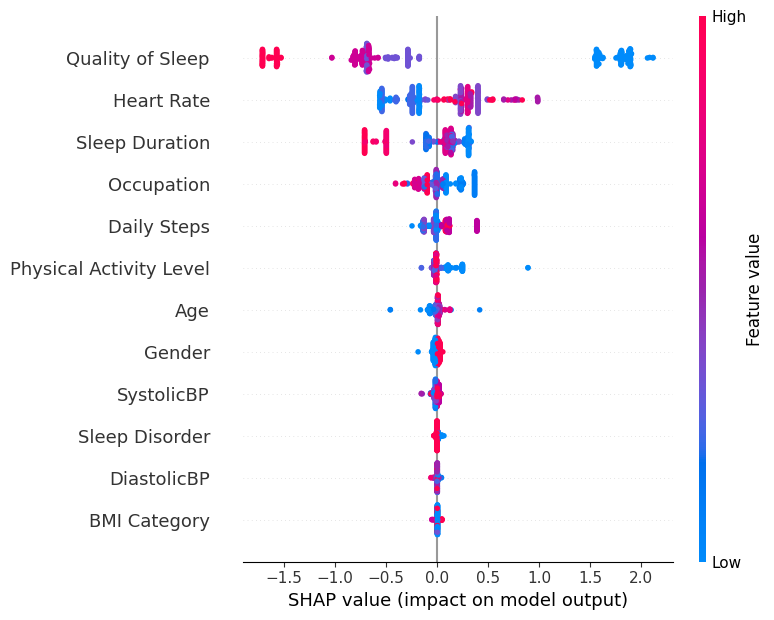

In [21]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np
import shap

df = pd.read_csv("sleep_encoded.csv")

feature_names = [
    'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
    'Physical Activity Level', 'BMI Category', 'Heart Rate',
    'Daily Steps', 'Sleep Disorder', 'SystolicBP', 'DiastolicBP'
]

X = df[feature_names]
y = df["Stress Level"]

model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X, y)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X, feature_names=feature_names)


In [22]:
# ============================================================
# SHAP Feature Importance using RandomForest + TreeExplainer
# ============================================================

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# ------------------------------------------------------------
# 1) Load encoded sleep dataset
# ------------------------------------------------------------
df = pd.read_csv("sleep_encoded.csv")

# These are the 12 features we use as inputs
feature_names = [
    'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep',
    'Physical Activity Level', 'BMI Category', 'Heart Rate',
    'Daily Steps', 'Sleep Disorder', 'SystolicBP', 'DiastolicBP'
]

X = df[feature_names]
y = df["Stress Level"]

# ------------------------------------------------------------
# 2) Train RandomForest
# ------------------------------------------------------------
model = RandomForestRegressor(
    n_estimators=400,
    max_depth=8,
    random_state=42
)
model.fit(X, y)

# ------------------------------------------------------------
# 3) TreeExplainer SHAP
# ------------------------------------------------------------
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# ------------------------------------------------------------
# 4) Beeswarm Summary Plot (Poster Quality)
# ------------------------------------------------------------
plt.figure()
shap.summary_plot(
    shap_values,
    X,
    feature_names=feature_names,
    show=False
)
plt.savefig("fig4_shap_clean.png", dpi=350, bbox_inches="tight")
plt.close()

print("✓ SHAP plot saved as fig4_shap_clean.png")


✓ SHAP plot saved as fig4_shap_clean.png
